# Visualize Database

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
from rdkit import Chem

from ast import literal_eval

def calc_mw(smile):
    try:
        return Chem.rdMolDescriptors.CalcExactMolWt(
            Chem.MolFromSmiles(smile))
    except:
        return 0

def get_max_mw(smiles):
    smiles = literal_eval(smiles)
    if isinstance(smiles, tuple):
        mws = [calc_mw(smiles[0])]
    else:
        mws = [calc_mw(s[0]) for s in smiles]
        
    return max(mws)

# Load Data

In [2]:
df_db = pd.read_csv("../../Data/Database/220426_stereo_MW_prepolymer.csv")
df_db["mw"] = df_db.monomers.apply(get_max_mw)

df_counts = df_db.smiles_monomer.value_counts().rename_axis('unique_values').reset_index(name='counts').counts.value_counts().rename_axis('samples_per_polymer').reset_index(name='counts')
df_counts = df_db.smiles_monomer.value_counts().rename_axis('unique_values').reset_index(name='counts')

# Mn Tg Data
df_Tg = pd.read_csv("TgData.csv")

# Convert Mn to grams/mol
df_Tg["Mn"] = df_Tg["Mn"] * 1000

# Subtract 273.15 from Tg for Polymer=="PC1St"
df_Tg.loc[df_Tg["Polymer"] == "PC1St", "Tg"] -= 273.15

# Subtract 273.15 from Tg for Polymer=="PET"
df_Tg.loc[df_Tg["Polymer"] == "PET", "Tg"] -= 273.15

# Plot Data

In [3]:
font = {'family' : 'helvetica',
        'weight' : 'bold',
        'size'   : 14}

legend_font_size = 8

matplotlib.rc('font', **font)
matplotlib.rc('legend', fontsize=legend_font_size)

/var/folders/mn/k32kn37x5ldgpp51c6cdmkpm0000gn/T/ipykernel_15955/388141060.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_plot = df_db[df_db.smiles_monomer.str.contains("|".join(df_counts.unique_values[df_counts.counts > min_counts]))]


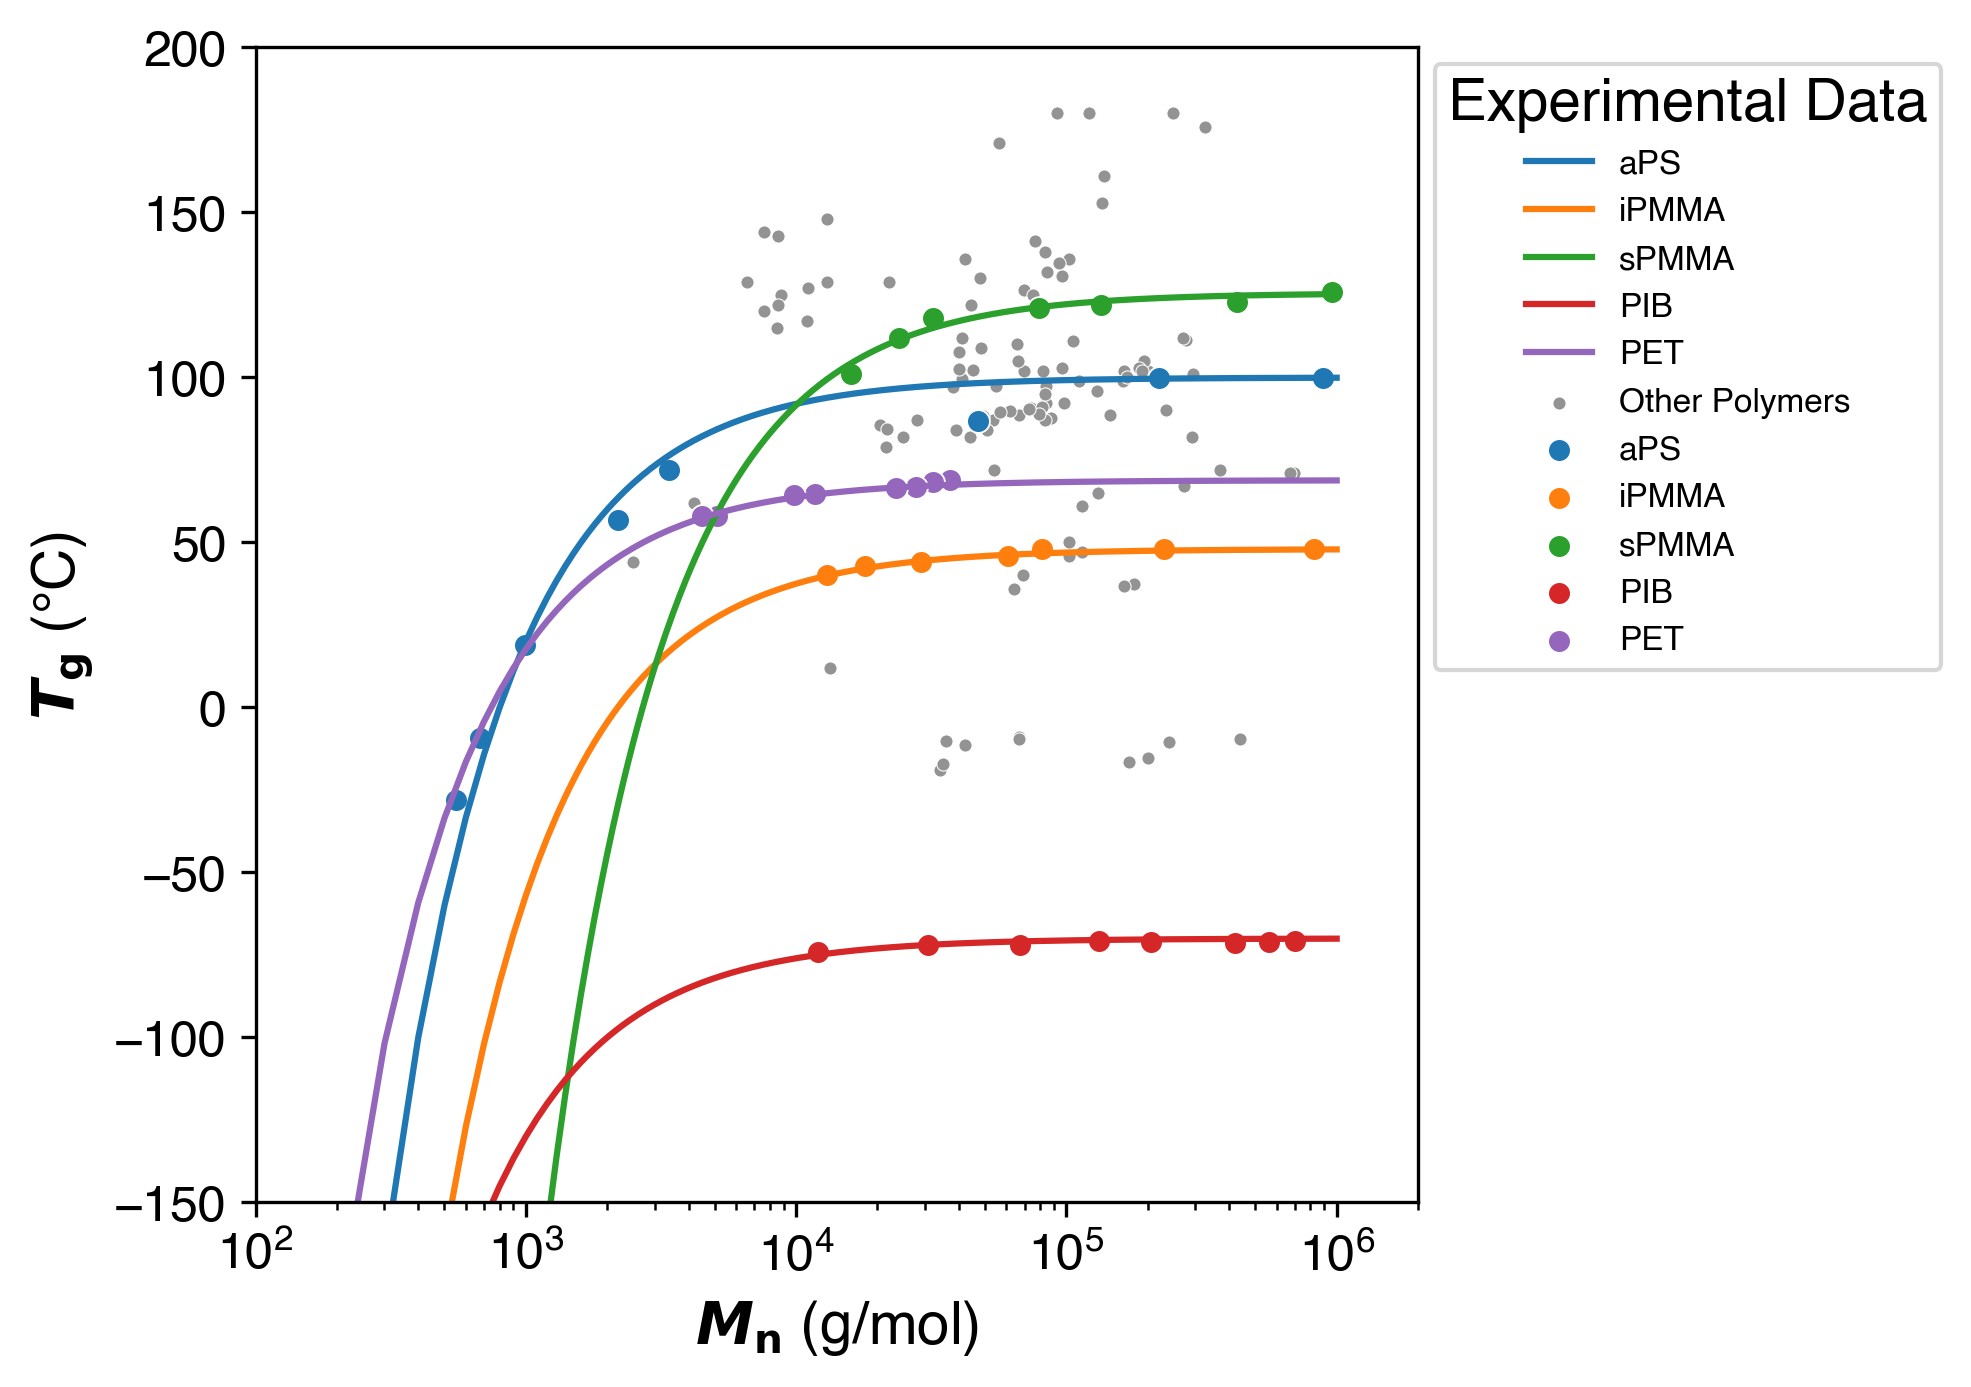

In [4]:
def FF_Tg(tg, mn, K):
#     tg_inv = 1/100 + K/(mn*(100**2))
#     return 1/tg_inv
    return tg - K/mn

ps_dfs = pd.DataFrame()
# https://doi.org/10.1002/polb.24326 [386.3-273.15, 1.05E5, "Atactic Poly(4-methyl styrene)"]
# https://onlinelibrary.wiley.com/doi/epdf/10.1002/pol.1966.160040204
for K in [[100, 0.8E5, "aPS"], [48, 1.05E5, "iPMMA"], [125.6, 3.40E5, "sPMMA"], [-70, .6E5, "PIB"],[342-273.15, 51200, "PET"]]:
    ps_ff = [[mn, np.log10(mn), FF_Tg(K[0], mn, K[1]), K[2]] for mn in range(200, 1000000, 100)]
    ps_ff = pd.DataFrame(ps_ff, columns=["Mn", "log_Mn", "Tg", "Polymer"])
    ps_ff.loc[:, "Tg_scaled"] = ps_ff.Tg/max(ps_ff.Tg)
    ps_dfs = pd.concat([ps_dfs, ps_ff])

ps_dfs = ps_dfs.reset_index(drop=True)

# Plot
min_counts = 2
df_plot = df_db[df_db.smiles_monomer.str.contains("|".join(df_counts.unique_values[df_counts.counts > min_counts]))]
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
# [ax.axvline(x=i, ymin=-1000, ymax=1000) for i in [10000, 100000]]

# Line plot for colored lines
sns.lineplot(x="Mn", y="Tg", data=ps_dfs, ax=ax, hue="Polymer")

# Scatter plot for alll dots
sns.scatterplot(x="Mn", y="Tg", data=df_plot[df_plot.Mn < 1E6], ax=ax, s=10, color="#939393", label="Other Polymers")
sns.scatterplot(x="Mn", y="Tg", data=df_plot[df_plot["smiles_monomer"] == "C=Cc1ccccc1"], label="aPS", ax=ax, s=30)
sns.scatterplot(x="Mn", y="Tg", data=df_Tg[df_Tg.Polymer == "iPMMA"], label="iPMMA", ax=ax, s=30)
sns.scatterplot(x="Mn", y="Tg", data=df_Tg[df_Tg.Polymer == "sPMMA"], label="sPMMA", ax=ax, s=30)
sns.scatterplot(x="Mn", y="Tg", data=df_Tg[df_Tg.Polymer == "PIB"], label="PIB", ax=ax, s=30)
sns.scatterplot(x="Mn", y="Tg", data=df_Tg[df_Tg.Polymer == "PET"], label="PET", ax=ax, s=30)


label_size = 14
tick_size = 12

ax.set_ylim(-150, 200)
ax.set_xlim(10E1, 2*10E5)
ax.set_xscale("log")
ax.set_xlabel(r"${M_{\mathrm{n}}}$ (g/mol)", fontsize=label_size, fontstyle='normal')
ax.set_ylabel(r"${T_\mathrm{{g}}}$ (°C)", fontsize=label_size, fontstyle='normal')

ax.tick_params(axis='x', labelsize=tick_size)
ax.tick_params(axis='y', labelsize=tick_size)
ax.legend(title="Experimental Data")
# ax.set_title("Polymers with > 5 Datapoints")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig.savefig("Figure_FoxFloryExperimental.png", dpi=300, bbox_inches="tight")